In [90]:
# fix annoying bug
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [91]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [92]:
cuda_id = torch.cuda.current_device()
torch.cuda.get_device_name(cuda_id)

'NVIDIA GeForce GTX 1070 Ti'

In [93]:
data_transform = transform=torchvision.transforms.Compose([
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1) # [0,1] -> [-1,1]
    ])
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transform
)
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

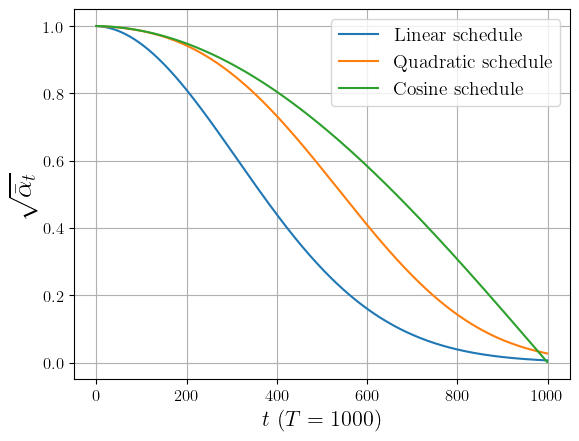

In [145]:
def linear_schedule(T):
    beta = torch.linspace(1e-4,0.02,T).to(device)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    return beta,alpha,alpha_bar

def quadratic_schedule(T):
    beta = torch.linspace(1e-4**0.5, 0.02**0.5, T,device=device)**2
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    return beta,alpha,alpha_bar

def cosine_schedule(T):
    s = 0.008
    f = lambda t: torch.cos( (t/T + s)/(1+s) * torch.pi/2 ) ** 2
    ts = torch.arange(0,T,1,device=device)
    alpha_bar = f(ts) / f(ts[0])

    # alpha_bar = torch.clip(alpha_bar,min=0.0,max=0.999)
    alpha = torch.zeros(T,device=device)
    alpha[0] = alpha_bar[0]
    alpha[1:] = alpha_bar[1:]/alpha_bar[:-1]
    beta = torch.clip(1 - alpha,min=0.001,max=0.999)
    alpha = 1 - beta

    return beta,alpha,alpha_bar


from matplotlib import rc
plt.rcParams.update({'font.size': 12})
rc('text', usetex=True)
rc('font', family='serif')

T = 1000
beta,alpha,alpha_bar = linear_schedule(T)
plt.plot((alpha_bar.cpu().numpy())**0.5, label='Linear schedule')

beta,alpha,alpha_bar = quadratic_schedule(T)
plt.plot((alpha_bar.cpu().numpy())**0.5, label='Quadratic schedule')

beta,alpha,alpha_bar = cosine_schedule(T)
plt.plot((alpha_bar.cpu().numpy())**0.5, label='Cosine schedule')

plt.ylabel(r'$\sqrt{\bar{\alpha}_t}$', fontsize=20)
plt.xlabel(r'$t$   $(T=1000)$', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig('alpha_bar_schedules.pdf', format='pdf', dpi=300)
plt.show()

In [95]:
### DDPM global variables
IMAGE_SHAPE = torch.tensor(training_data[0][0].shape)

T = 1000
# beta,alpha,alpha_bar = linear_schedule(T)
# beta,alpha,alpha_bar = quadratic_schedule(T)
beta,alpha,alpha_bar = cosine_schedule(T)

### SN model
# from NNs.mnist_SN import ScoreNetwork0
# flatten = True
# model = ScoreNetwork0().to(device)

### More advanced  UNet
from NNs.mnist_unet import UNet
flatten = False
model = UNet(in_channels=1, n_steps=T).to(device)

### Loss and optimizer
loss_fn = torch.nn.MSELoss()
lr = [1e-3,1e-4,3e-4][2]
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

tensor(1., device='cuda:0')


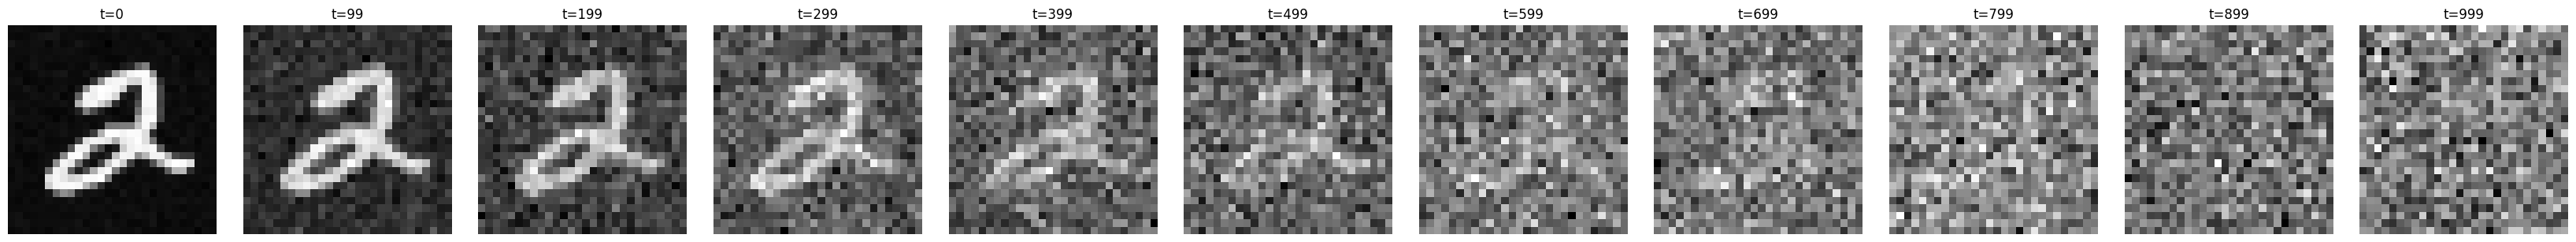

In [96]:
### Forward process

def forward_diffusion(x0, t):
    if not torch.is_tensor(t):
        t = torch.tensor(t)
    if t.dim() == 0:
        t = t.unsqueeze(0)
    
    t = t[...,None,None].to(device)
    eps = torch.normal(mean=0, std=torch.ones(x0.shape)).to(device)
    xt = alpha_bar[t]**0.5 * x0 + (1 - alpha_bar[t])**0.5 * eps
    return xt, eps

def viz_forward_process(x0_index,num_im=9):
    ts = np.linspace(0,T-1,num=num_im,dtype=int)
    x0 = training_data[x0_index][0].to(device)

    fig, ax = plt.subplots(1, num_im, figsize=(3*num_im, 3))
    for i,t in enumerate(ts):
        xt,eps = forward_diffusion(x0,t)
        # print(xt.cpu().squeeze())
        ax[i].imshow(xt.cpu().squeeze(), cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(f"t={t}")
    
    plt.tight_layout()
    plt.show()

viz_forward_process(x0_index=5,num_im=11)

In [97]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        cur_batch_size = X.shape[0]
        X = X.to(device)
        t = torch.randint(low=0, high=T-1, size=(cur_batch_size,1), device=device)
        Xt, eps = forward_diffusion(X, t)

        ##### ScoreNetwork
        if flatten:
            Xt = Xt.reshape(cur_batch_size, -1)
            # Compute prediction and loss
            pred = model(Xt, t)
            loss = loss_fn(pred.reshape(cur_batch_size, *IMAGE_SHAPE), eps)
        else:
            ##### UNet
            # Compute prediction and loss
            pred = model(Xt, t)
            loss = loss_fn(pred, eps)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 50 == 0:
        # if batch % 5 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [115]:
 # Training
epochs = 9
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.056473  [  128/60000]
loss: 0.054254  [ 6528/60000]
loss: 0.049117  [12928/60000]
loss: 0.052343  [19328/60000]
loss: 0.050474  [25728/60000]
loss: 0.052132  [32128/60000]
loss: 0.057373  [38528/60000]
loss: 0.048416  [44928/60000]
loss: 0.058970  [51328/60000]
loss: 0.046200  [57728/60000]
Epoch 2
-------------------------------
loss: 0.051136  [  128/60000]
loss: 0.046056  [ 6528/60000]
loss: 0.045296  [12928/60000]
loss: 0.053455  [19328/60000]
loss: 0.050204  [25728/60000]
loss: 0.049031  [32128/60000]
loss: 0.044161  [38528/60000]
loss: 0.043173  [44928/60000]
loss: 0.054683  [51328/60000]
loss: 0.041803  [57728/60000]
Epoch 3
-------------------------------
loss: 0.045770  [  128/60000]
loss: 0.046282  [ 6528/60000]
loss: 0.044156  [12928/60000]
loss: 0.048752  [19328/60000]
loss: 0.059185  [25728/60000]
loss: 0.046105  [32128/60000]
loss: 0.049847  [38528/60000]
loss: 0.046299  [44928/60000]
loss: 0.042935  [51328/60000]
loss: 0.04

In [117]:
def viz_sampling(num_viz=9, flatten=False):
    model.eval()
    with torch.no_grad():
        sig = beta**0.5
        x = torch.normal(mean=0, std=torch.ones(*IMAGE_SHAPE)).to(device)

        t_values = np.linspace(0, T-1, num=num_viz, dtype=int)
        fig, ax = plt.subplots(1, num_viz, figsize=(3*num_viz, 3))  # Create subplots with 1 row and `num_images` columns

        for t in range(T-1, -1, -1):
            t_val = t
            if t > 0:
                z = torch.normal(mean=0, std=torch.ones(*IMAGE_SHAPE)).to(device)
            else:
                z = torch.zeros(*IMAGE_SHAPE).to(device)
            t = torch.tensor([t]).to(device)

            if flatten: ### ScoreNetwork
                eps_theta = model(x.flatten(), t).reshape(*IMAGE_SHAPE)
            else: ### UNet
                eps_theta = model(x, t)

            x = 1/alpha[t]**0.5 * (x - (1-alpha[t])/(1-alpha_bar[t])**0.5 * eps_theta) + \
                    sig[t] * z

            if t_val in t_values:
                idx = t_values.tolist().index(t_val)
                xt_image = x.detach().cpu().squeeze()
                xt_image = torch.clamp(xt_image, min=-1.0, max=1.0)
                xt_image = (xt_image + 1.0) / 2.0
                ax[num_viz-1-idx].imshow(xt_image, cmap='gray')
                ax[idx].axis('off')
                ax[idx].set_title(f"t={t_val}")

        plt.tight_layout()
        plt.show()    
        return x.detach()

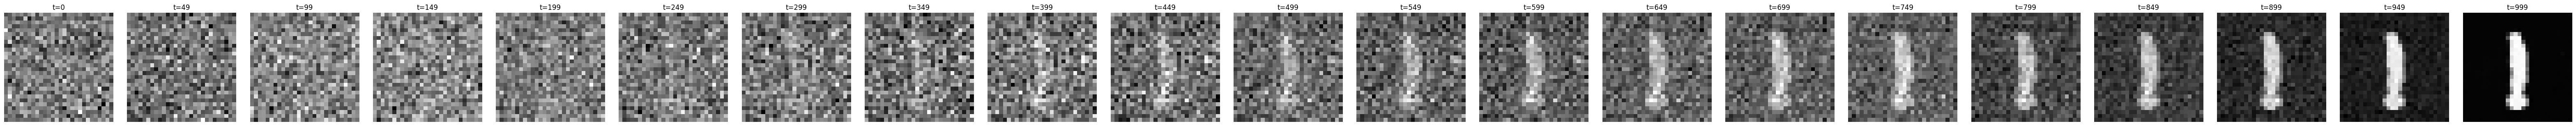

In [118]:
x_sample = viz_sampling(num_viz=21,flatten=flatten)

In [119]:
def sampling(flatten=False):
    model.eval()
    with torch.no_grad():
        sig = beta**0.5
        x = torch.normal(mean=0, std=torch.ones(*IMAGE_SHAPE)).to(device)
        for t in range(T-1, -1, -1):
            if t > 0:
                z = torch.normal(mean=0, std=torch.ones(*IMAGE_SHAPE)).to(device)
            else:
                z = torch.zeros(*IMAGE_SHAPE).to(device)
            t = torch.tensor([t]).to(device)

            if flatten: ### ScoreNetwork
                eps_theta = model(x.flatten(), t).reshape(*IMAGE_SHAPE)
            else: ### UNet
                eps_theta = model(x, t)
            
            x = 1/alpha[t]**0.5 * (x - (1-alpha[t])/(1-alpha_bar[t])**0.5 * eps_theta) + \
                    sig[t] * z
        
        return x.detach()

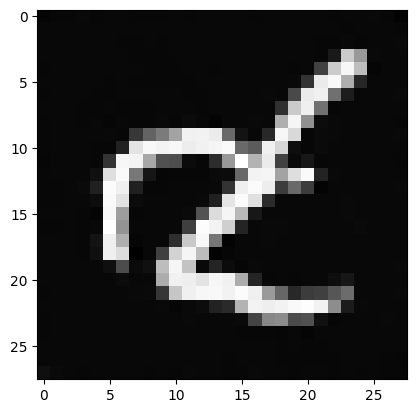

In [120]:
x_sample = sampling(flatten=False)
xt_image = x_sample.cpu().squeeze()
xt_image = torch.clamp(xt_image, min=-1.0, max=1.0)
xt_image = (xt_image + 1.0) / 2.0
plt.imshow(xt_image, cmap='gray')

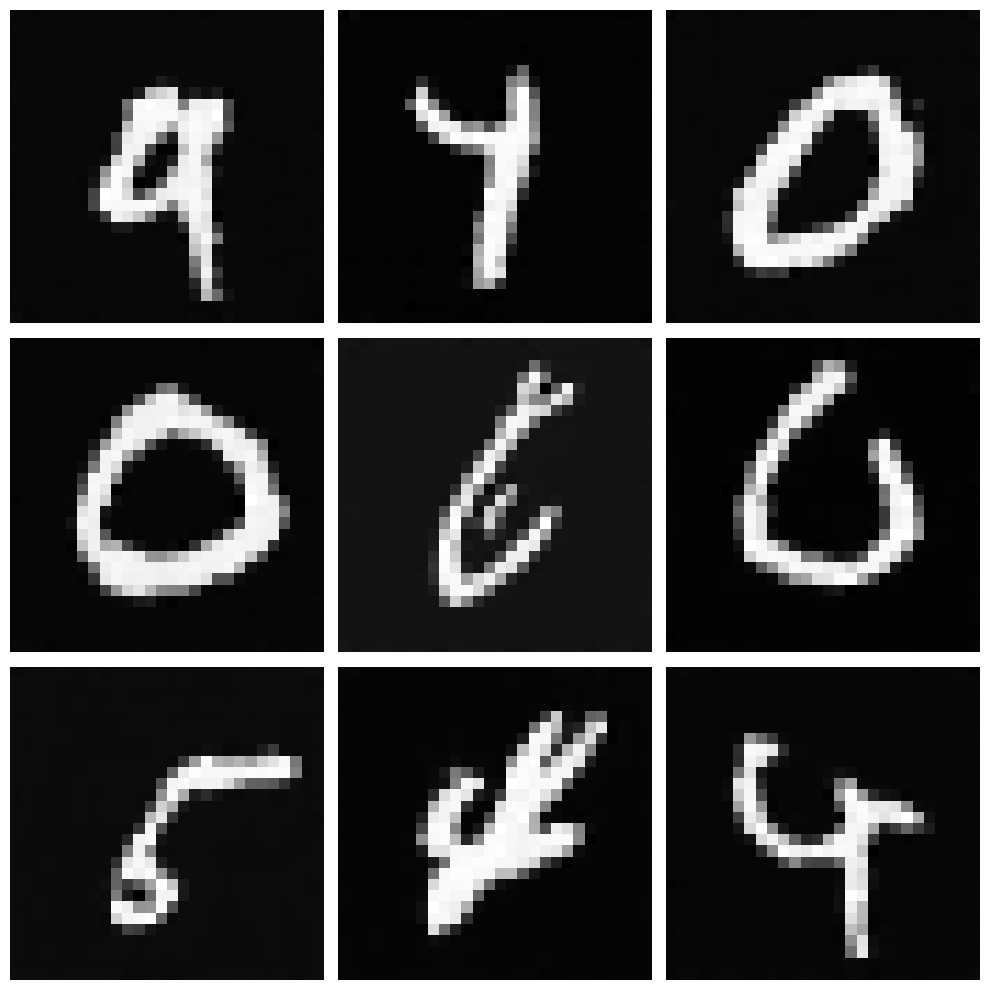

In [121]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    x_sample = sampling(flatten=flatten)
    xt_image = x_sample.cpu().squeeze()
    xt_image = torch.clamp(xt_image, min=-1.0, max=1.0)
    xt_image = (xt_image + 1.0) / 2.0
    ax.imshow(xt_image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [127]:
# torch.save(model.state_dict(), 'mnist_cosine_model_weights.pth')